report: 
The successful rate for all four model is 100%. Given a target, we can always get desire result in certain iterations. You can change your target picture freely. Time cost and number of iteration may vary for different target. eps I choose is 0.03 which according to my test works for all models. If eps is too large, attack resnet-18 will become inconsistent. The size of the target image could not smaller than 256*256.



In [4]:
import torch
import torch.nn
import time
#from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
!pip3 install foolbox==3.1.1
import foolbox as fb
#import linalg to calculate p-norm
from numpy import linalg as LA
import eagerpy as ep

def zero_gradients(i):
    for t in iter_gradients(i):
        t.zero_()

comment the model that you are not currently testing

##choose a model

In [5]:
#model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

##choose image

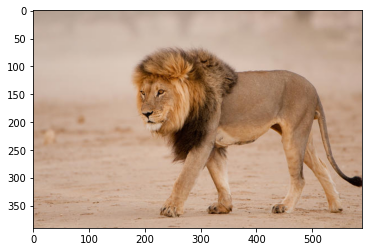

In [6]:
# you can choose whatever image you like. I choose image from google image as my target.
import urllib
url, filename = ("http://www.krugerpark.co.za/images/black-maned-lion-shem-compion-590x390.jpg", "lion.jpg")
urllib.request.urlretrieve(url, filename)
input_image = Image.open(filename)
plt.imshow(input_image)

## preprocess

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

In [8]:
original = input_batch

after preprocess, image will looks like this. 

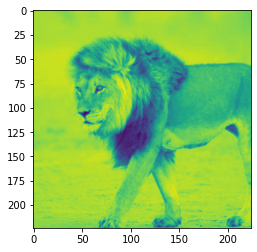

In [9]:
plt.imshow(input_batch.cpu().detach().numpy()[0][0])

In [10]:

input_batch=input_batch.to('cuda') #comment this line out if CPU only
input_batch.requires_grad=True
model.to('cuda') #comment this line out if CPU only
output = model(input_batch)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

import categories list'imagenet_classes.txt' from github. You can import the file to your google drive.

In [11]:
from google.colab import drive
with open("/content/drive/MyDrive/imagenet_classes.txt", "r") as f: # you can download from https://github.com/Yifei-Li1/imagenet_classes/blob/main/imagenet_classes.txt
    categories = [s.strip() for s in f.readlines()]

first prediction

In [12]:

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

print('----------------------------------------------------')


291, lion 0.99729984998703
231, collie 0.0006902170134708285
230, Shetland_sheepdog 0.0004986550775356591
354, Arabian_camel 0.000373626098735258
676, muzzle 0.0002362161030760035
----------------------------------------------------


In [13]:
def plot_img(input_image):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(input_image[0])
    t[:,:,0] = input_image[0][:,:,2]
    t[:,:,1] = input_image[0][:,:,1]
    t[:,:,2] = input_image[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show(input_image)

The attack, I let the iteration stop whenever the most posible prediction is our desired target.

In [14]:
start_time = time.time()
for i in range(500):
  output = model(input_batch)
  print('----------------------------------------------------')
  y = 943   #cucumber, or change to whatever you like  
  target = Variable(torch.LongTensor([y]), requires_grad=False)
  target=target.to('cuda') #comment this line out if CPU only
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, target)
  loss_cal.backward(retain_graph=True)
  eps = 0.03 # works for every model
  x_grad = torch.sign(input_batch.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
  input_batch.data = input_batch.data - eps * x_grad          #find adv example using formula shown above
  output_adv = model.forward(Variable(input_batch.data))   #perform a forward pass on adv example
  
  op_adv_probs = F.softmax(output_adv[0], dim=0)                 #get probability distribution over classes
  top5_prob, top5_catid = torch.topk(op_adv_probs, 5)

  for j in range(top5_prob.size(0)):
      print(i, categories[top5_catid[j]], top5_prob[j].item())
  if(categories[top5_catid[0]] == categories[y]):       #you can comment this if you want to increase the prediction result.
    break             #you can comment this if you want to further increase the prediction result.
timeCost = [time.time() - start_time]   #get the time cost of the attack
print("Time cost: ")
print(timeCost)

----------------------------------------------------
0 230, Shetland_sheepdog 0.15545068681240082
0 154, Pekinese 0.14559978246688843
0 259, Pomeranian 0.10014822334051132
0 185, Norfolk_terrier 0.05047866702079773
0 186, Norwich_terrier 0.050241559743881226
----------------------------------------------------
1 187, Yorkshire_terrier 0.04591984674334526
1 377, marmoset 0.04173104465007782
1 380, titi 0.037488460540771484
1 722, ping-pong_ball 0.03309197351336479
1 434, bath_towel 0.02897103689610958
----------------------------------------------------
2 187, Yorkshire_terrier 0.038982655853033066
2 722, ping-pong_ball 0.03060135431587696
2 380, titi 0.027581868693232536
2 377, marmoset 0.022317377850413322
2 697, pajama 0.020352039486169815
----------------------------------------------------
3 948, Granny_Smith 0.04507594555616379
3 380, titi 0.02957764081656933
3 929, ice_lolly 0.02693130075931549
3 187, Yorkshire_terrier 0.023635927587747574
3 722, ping-pong_ball 0.0234865508973598

result image after attack

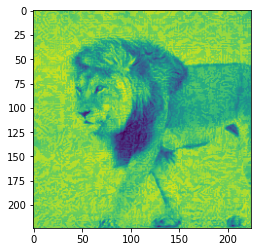

In [15]:
plt.imshow(input_batch.cpu().detach().numpy()[0][0])

In [16]:
p_norm = []
#L0
p_norm.append(LA.norm(fb.distances.l0(original, input_batch.cpu()).detach().numpy())) 
#L1
p_norm.append(LA.norm(fb.distances.l1(original, input_batch.cpu()).detach().numpy()))
#L2
p_norm.append(LA.norm(fb.distances.l2(original, input_batch.cpu()).detach().numpy()))
#Linf
p_norm.append(LA.norm(fb.distances.linf(original, input_batch.cpu()).detach().numpy()))
print(p_norm)

[145775.0, 30169.719, 81.99453, 0.24000001]
